In [1]:
from google.colab.patches import cv2_imshow

# 1.沒有用任何模組

## Imports and Utility Functions

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2

def extract_features(image):
    gradient = np.sqrt(ndimage.sobel(image, axis=0)**2 + ndimage.sobel(image, axis=1)**2)
    keypoints = []
    threshold = 0.1 * gradient.max()
    for y in range(1, gradient.shape[0] - 1):
        for x in range(1, gradient.shape[1] - 1):
            if (gradient[y, x] > threshold).all() and \
                (gradient[y, x] > np.array([gradient[y-1, x], gradient[y+1, x], gradient[y, x-1], gradient[y, x+1]])).all():
                keypoints.append((x, y))

    features = []
    for kp in keypoints:
        x, y = kp
        patch = image[max(0, y-8):min(image.shape[0], y+8), max(0, x-8):min(image.shape[1], x+8)]
        features.append(patch.flatten())

    return keypoints, features

def matchKeyPoint(kps_l, kps_r, features_l, features_r, ratio):
    Match_idxAndDist = []
    for i in range(len(features_l)):
        min_IdxDis = [-1, np.inf]
        secMin_IdxDis = [-1, np.inf]
        for j in range(len(features_r)):
            if features_l[i].shape != features_r[j].shape:
                continue
            dist = np.linalg.norm(features_l[i] - features_r[j])
            if min_IdxDis[1] > dist:
                secMin_IdxDis = np.copy(min_IdxDis)
                min_IdxDis = [j, dist]
            elif secMin_IdxDis[1] > dist and secMin_IdxDis[1] != min_IdxDis[1]:
                secMin_IdxDis = [j, dist]

        Match_idxAndDist.append([min_IdxDis[0], min_IdxDis[1], secMin_IdxDis[0], secMin_IdxDis[1]])

    goodMatches = []
    for i in range(len(Match_idxAndDist)):
        if Match_idxAndDist[i][1] <= Match_idxAndDist[i][3] * ratio:
            goodMatches.append((i, Match_idxAndDist[i][0]))

    goodMatches_pos = []
    for (idx, correspondingIdx) in goodMatches:
        psA = (int(kps_l[idx][0]), int(kps_l[idx][1]))
        psB = (int(kps_r[correspondingIdx][0]), int(kps_r[correspondingIdx][1]))
        goodMatches_pos.append([psA, psB])

    return goodMatches_pos

def drawMatches(imgs, matches_pos):
    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]
    vis = np.zeros((max(hl, hr), wl + wr, 3), dtype="uint8")
    vis[0:hl, 0:wl] = img_left
    vis[0:hr, wl:] = img_right

    for (img_left_pos, img_right_pos) in matches_pos:
        pos_l = img_left_pos
        pos_r = img_right_pos[0] + wl, img_right_pos[1]
        plt.plot([pos_l[0], pos_r[0]], [pos_l[1], pos_r[1]], color='blue')
        plt.scatter([pos_l[0], pos_r[0]], [pos_l[1], pos_r[1]], color=['red', 'green'])
    plt.imshow(vis)
    plt.title("Matching points")
    plt.show()

def solve_homography(src_points, dst_points):
    A = []
    for i in range(src_points.shape[0]):
        x, y = src_points[i, 0], src_points[i, 1]
        u, v = dst_points[i, 0], dst_points[i, 1]
        A.append([-x, -y, -1, 0, 0, 0, u * x, u * y, u])
        A.append([0, 0, 0, -x, -y, -1, v * x, v * y, v])

    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))

    return H

## RANSAC and Warping Functions

In [3]:
def estimate_homography_ransac(matches_pos):
    dstPoints = []
    srcPoints = []
    for dstPoint, srcPoint in matches_pos:
        dstPoints.append(list(dstPoint))
        srcPoints.append(list(srcPoint))
    dstPoints = np.array(dstPoints)
    srcPoints = np.array(srcPoints)

    NumSample = len(matches_pos)
    threshold = 5.0
    NumIter = 8000
    NumRamdomSubSample = 4
    MaxInlier = 0
    Best_H = None

    for run in range(NumIter):
        SubSampleIdx = random.sample(range(NumSample), NumRamdomSubSample)
        H = solve_homography(srcPoints[SubSampleIdx], dstPoints[SubSampleIdx])

        NumInlier = 0
        for i in range(NumSample):
            if i not in SubSampleIdx:
                concateCoor = np.hstack((srcPoints[i], [1]))
                dstCoor = H @ concateCoor.T
                if dstCoor[2] <= 1e-8:
                    continue
                dstCoor = dstCoor / dstCoor[2]
                if np.linalg.norm(dstCoor[:2] - dstPoints[i]) < threshold:
                    NumInlier += 1
        if MaxInlier < NumInlier:
            MaxInlier = NumInlier
            Best_H = H

    print("The Number of Maximum Inlier:", MaxInlier)

    return Best_H

def warp(imgs, HomoMat):
    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]
    stitch_img = np.zeros((max(hl, hr), wl + wr, 3), dtype="int")

    inv_H = np.linalg.inv(HomoMat)
    for i in range(stitch_img.shape[0]):
        for j in range(stitch_img.shape[1]):
            coor = np.array([j, i, 1])
            img_right_coor = inv_H @ coor
            img_right_coor /= img_right_coor[2]

            y, x = int(round(img_right_coor[0])), int(round(img_right_coor[1]))

            if x < 0 or x >= hr or y < 0 or y >= wr:
                continue
            stitch_img[i, j] = img_right[x, y]

    stitch_img = linearBlending([img_left, stitch_img])
    stitch_img = removeBlackBorder(stitch_img)

    return stitch_img

def removeBlackBorder(img):
    h, w = img.shape[:2]
    reduced_h, reduced_w = h, w
    for col in range(w - 1, -1, -1):
        all_black = True
        for i in range(h):
            if np.count_nonzero(img[i, col]) > 0:
                all_black = False
                break
        if all_black:
            reduced_w -= 1

    for row in range(h - 1, -1, -1):
        all_black = True
        for i in range(reduced_w):
            if np.count_nonzero(img[row, i]) > 0:
                all_black = False
                break
        if all_black:
            reduced_h -= 1

    return img[:reduced_h, :reduced_w]

def linearBlending(imgs):
    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]

    centerX = wl // 2
    for i in range(hl):
        for j in range(centerX, wl):
            if np.count_nonzero(img_right[i, j]) > 0:
                alpha = 1 - ((j - centerX) / (wl - centerX))
                img_left[i, j] = img_left[i, j] * alpha + img_right[i, j] * (1 - alpha)

    return img_left

## Stitching Functions

In [4]:
def stitch2_img(imgs, ratio):
    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]
    print("Left img size (", hl, "*", wl, ")")
    print("Right img size (", hr, "*", wr, ")")

    kps_l, features_l = extract_features(img_left)
    kps_r, features_r = extract_features(img_right)

    matches_pos = matchKeyPoint(kps_l, kps_r, features_l, features_r, ratio)
    print("The number of matching points:", len(matches_pos))
    drawMatches([img_left, img_right], matches_pos)
    HomoMat = estimate_homography_ransac(matches_pos)

    warp_img = warp([img_left, img_right], HomoMat)

    return warp_img

def stitch_image(imgs, ratio=0.75):
    img_left, img_mid, img_right = imgs
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    img_mid = cv2.cvtColor(img_mid, cv2.COLOR_BGR2RGB)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

    # Stitch the left and middle images
    warp_left_mid = stitch2_img([img_left, img_mid], ratio)
    warp_left_mid = np.clip(warp_left_mid, 0, 255).astype(np.uint8)

    # Display the intermediate result
    plt.imshow(warp_left_mid)
    plt.title("Warped Left and Middle Image")
    plt.axis('off')
    plt.show()

    # Stitch the result with the right image
    warp_img = stitch2_img([warp_left_mid, img_right], ratio)

    return warp_img

## Main

Left img size ( 450 * 420 )
Right img size ( 450 * 418 )
The number of matching points: 71


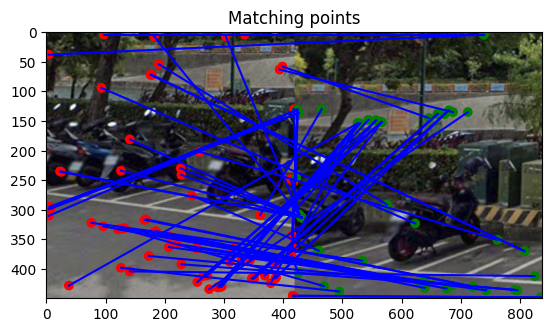

The Number of Maximum Inlier: 6


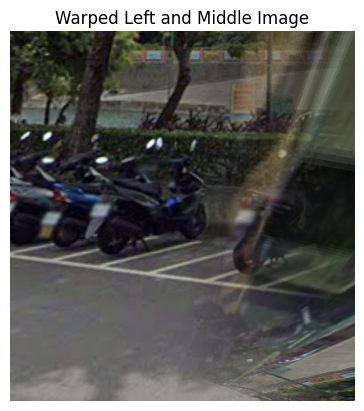

Left img size ( 450 * 420 )
Right img size ( 420 * 450 )
The number of matching points: 99


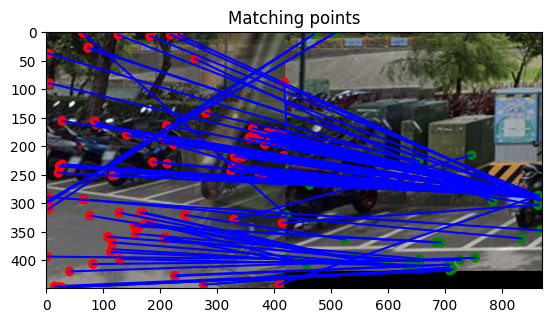

The Number of Maximum Inlier: 8


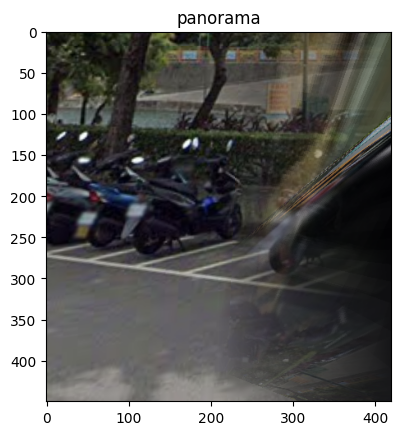

In [5]:
# Read the img file
img_left = cv2.imread('img1.png')
img_mid = cv2.imread('img2.png')
img_right = cv2.imread('img3.png')

# The stitch object to stitch the image
panorama = stitch_image([img_left, img_mid, img_right])

# plot the stitched image
plt.figure(13)
plt.title("panorama")
plt.imshow(panorama.astype(int))


# 2.有用一些模組

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2

def drawMatches(imgs, matches_pos):
    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]
    vis = np.zeros((max(hl, hr), wl + wr, 3), dtype="uint8")
    vis[0:hl, 0:wl] = img_left
    vis[0:hr, wl:] = img_right

    for (x1, y1, x2, y2) in matches_pos:
        pos_l = (x1, y1)
        pos_r = (x2 + wl, y2)
        plt.plot([pos_l[0], pos_r[0]], [pos_l[1], pos_r[1]], color='blue')
        plt.scatter([pos_l[0], pos_r[0]], [pos_l[1], pos_r[1]], color=['red', 'green'])
    plt.imshow(vis)
    plt.title("Matching points")
    plt.show()

def solve_homography(src_points, dst_points):
    A = []
    for i in range(src_points.shape[0]):
        x, y = src_points[i, 0], src_points[i, 1]
        u, v = dst_points[i, 0], dst_points[i, 1]
        A.append([-x, -y, -1, 0, 0, 0, u * x, u * y, u])
        A.append([0, 0, 0, -x, -y, -1, v * x, v * y, v])

    A = np.array(A)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))

    return H

def match_descriptors(des1, des2, ratio=0.75):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append((m.queryIdx, m.trainIdx))
    return good_matches


In [13]:
def estimate_homography_ransac(matches_pos):
    dstPoints = []
    srcPoints = []
    for (x1, y1, x2, y2) in matches_pos:
        dstPoints.append([x2, y2])
        srcPoints.append([x1, y1])
    dstPoints = np.array(dstPoints)
    srcPoints = np.array(srcPoints)

    NumSample = len(matches_pos)
    threshold = 5.0
    NumIter = 8000
    NumRamdomSubSample = 4
    MaxInlier = 0
    Best_H = None

    for run in range(NumIter):
        SubSampleIdx = random.sample(range(NumSample), NumRamdomSubSample)
        H = solve_homography(srcPoints[SubSampleIdx], dstPoints[SubSampleIdx])

        NumInlier = 0
        for i in range(NumSample):
            if i not in SubSampleIdx:
                concateCoor = np.hstack((srcPoints[i], [1]))
                dstCoor = H @ concateCoor.T
                if dstCoor[2] <= 1e-8:
                    continue
                dstCoor = dstCoor / dstCoor[2]
                if np.linalg.norm(dstCoor[:2] - dstPoints[i]) < threshold:
                    NumInlier += 1
        if MaxInlier < NumInlier:
            MaxInlier = NumInlier
            Best_H = H

    print("The Number of Maximum Inlier:", MaxInlier)

    return Best_H

def warp(imgs, HomoMat):
    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]

    # 定義拼接後圖像的尺寸，留一些冗余以避免邊界問題
    stitch_img = np.zeros((max(hl, hr), wl + 2 * wr, 3), dtype="int")
    stitch_img[:hl, :wl] = img_left

    for i in range(stitch_img.shape[0]):
        for j in range(stitch_img.shape[1]):
            coor = np.array([j, i, 1])
            img_right_coor = HomoMat @ coor
            img_right_coor /= img_right_coor[2]
            x, y = int(round(img_right_coor[0])), int(round(img_right_coor[1]))

            if 0 <= x < wr and 0 <= y < hr:
                stitch_img[i, j] = img_right[y, x]

    return stitch_img

def removeBlackBorder(img):
    h, w = img.shape[:2]
    reduced_h, reduced_w = h, w
    for col in range(w - 1, -1, -1):
        all_black = True
        for i in range(h):
            if np.count_nonzero(img[i, col]) > 0:
                all_black = False
                break
        if all_black:
            reduced_w -= 1

    for row in range(h - 1, -1, -1):
        all_black = True
        for i in range(reduced_w):
            if np.count_nonzero(img[row, i]) > 0:
                all_black = False
                break
        if all_black:
            reduced_h -= 1

    return img[:reduced_h, :reduced_w]

def linearBlending(imgs):
    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]

    # 計算混合區域
    blend_width = wl // 10
    for i in range(hl):
        for j in range(wl - blend_width, wl):
            alpha = (j - (wl - blend_width)) / blend_width
            img_left[i, j] = img_left[i, j] * (1 - alpha) + img_right[i, j - wl + wr] * alpha

    return img_left


In [14]:
def extract_and_match_features(img1, img2, ratio=0.75):
    sift = cv2.SIFT_create(nfeatures=1000)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    match_indices = match_descriptors(des1, des2, ratio)
    matches = [(int(kp1[i].pt[0]), int(kp1[i].pt[1]), int(kp2[j].pt[0]), int(kp2[j].pt[1])) for (i, j) in match_indices]
    return matches

def stitch2_img(imgs, ratio):
    img_left, img_right = imgs
    (hl, wl) = img_left.shape[:2]
    (hr, wr) = img_right.shape[:2]
    print("Left img size (", hl, "*", wl, ")")
    print("Right img size (", hr, "*", wr, ")")

    matches = extract_and_match_features(img_left, img_right, ratio)
    print("The number of matching points:", len(matches))
    drawMatches([img_left, img_right], matches)
    HomoMat = estimate_homography_ransac(matches)

    warp_img = warp([img_left, img_right], HomoMat)
    warp_img = removeBlackBorder(warp_img)

    return warp_img

def stitch_image(imgs, ratio=0.75):
    img_left, img_mid, img_right = imgs
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    img_mid = cv2.cvtColor(img_mid, cv2.COLOR_BGR2RGB)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

    # Stitch the left and middle images
    warp_left_mid = stitch2_img([img_left, img_mid], ratio)
    warp_left_mid = np.clip(warp_left_mid, 0, 255).astype(np.uint8)

    # Display the intermediate result
    plt.imshow(warp_left_mid)
    plt.title("Warped Left and Middle Image")
    plt.axis('off')
    plt.show()

    # Stitch the result with the right image
    warp_img = stitch2_img([warp_left_mid, img_right], ratio)
    warp_img = removeBlackBorder(warp_img)

    return warp_img

Left img size ( 775 * 904 )
Right img size ( 794 * 620 )
The number of matching points: 168


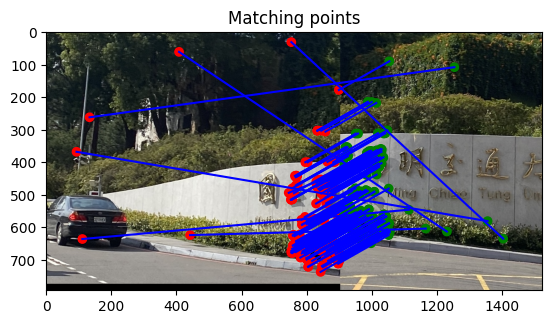

The Number of Maximum Inlier: 157


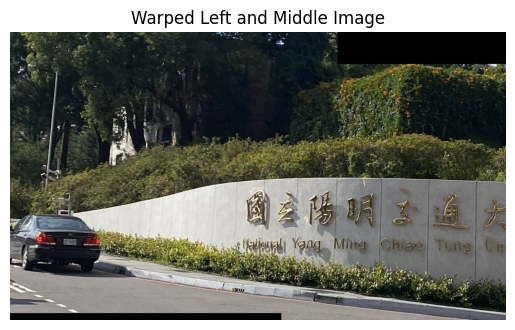

Left img size ( 794 * 1369 )
Right img size ( 824 * 667 )
The number of matching points: 52


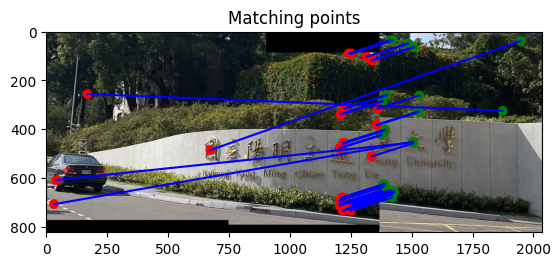

The Number of Maximum Inlier: 44


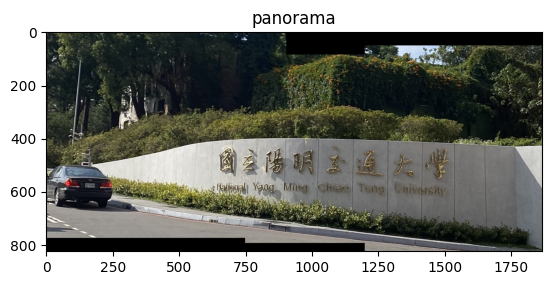

In [15]:
# Read the img file
img_left = cv2.imread('IMG_10.jpg')
img_mid = cv2.imread('IMG_11.jpg')
img_right = cv2.imread('IMG_12.jpg')


# The stitch object to stitch the image
panorama = stitch_image([img_left, img_mid, img_right])

# plot the stitched image
plt.figure(13)
plt.title("panorama")
plt.imshow(panorama.astype(int))
